# Projeto de Disciplina - Análise de Filmes com Baixa Avaliação/IMDb Filmes
Universidade Federal de São Carlos

Curso: Bacharelado em Ciência da Computação de Sorocaba

Disciplina: Novas Tecnologias de Bancos de Dados

Professora: Profa. Dra. Sahudy Montenegro González
### Grupo 07
**Integrantes:**
* Pedro Andrade Dorighello - 824321
* Jean Lucas Rocha dos Santos - 823597
### Resumo
Este notebook implementa o pipeline ETL completo para o projeto de Data Warehouse do IMDb. O fluxo abrange a ingestão de dados brutos e enriquecimento via API OMDb (Bronze), limpeza e padronização com persistência em Delta (Prata) e modelagem dimensional em esquema estrela (Ouro). Por fim, são executadas análises SQL que visam responder o que diretores, roteiristas, gêneros ou orçamentos têm em comum quando um filme "falha" em termos de avaliação e aceitação popular (definidos aqui como imdbRating < 6.0).

**Backup:** https://drive.google.com/drive/u/2/folders/1ooddhZwhgh0h7Y0eMF0xW9-P_SenAO6f
 - Dataframe da camada Silver: *silver_clean.csv*
 - Arquivos *.tsv.gz* do dataset do IMDb para a camada Bronze

### Objetivos de Análise (Requisitos de Negócio)

Este Data Warehouse foi projetado para responder às seguintes perguntas de negócio:

1.  **Análise de Risco por Gênero e Público-Alvo:** Qual a bilheteria média de filmes mal avaliados nos gêneros 'Terror' e 'Comédia' com mais de 10000 votos, segmentada por ano de lançamento e por classificação indicativa?
2.  **Análise de Padrões de Fracasso de Diretores:** Quais são os diretores que, na última década, dirigiram 3 ou mais filmes de um mesmo gênero com avaliação inferior a 6.0? Para estes diretores, qual foi a evolução da nota média de seus filmes nesse gênero específico, ano a ano?
3.  **Análise de Sinergia Criativa:** Quais são as duplas de diretor e roteirista que mais trabalharam juntas em filmes de baixo desempenho?

### Diagrama de Fluxo do Pipeline ETL

Para visualizar todo o processo de dados, desde a extração das fontes brutas até a carga no Data Warehouse final, construímos um fluxograma detalhado inspirado na abordagem de ferramentas de ETL como o Pentaho PDI. Este diagrama serve como um mapa para o pipeline implementado nas seções a seguir.

O fluxo está organizado seguindo a **Arquitetura Medalhão**, com seções claras para as camadas Bronze (ingestão e enriquecimento), Silver (limpeza e padronização) e Gold (modelagem dimensional). Cada caixa representa uma etapa lógica do processo, mostrando como os dados são transformados e movidos através do pipeline até formarem o modelo estrela final.

![Pipiline ETL](https://i.imgur.com/9rGWguF.png)

### Camada Bronze

![Pipiline ETL](https://i.imgur.com/Tp5ghLI.png)

### Camada Silver

![Pipiline ETL](https://i.imgur.com/KCrbT4I.png)

### Camada Gold

![Pipiline ETL](https://i.imgur.com/WMBXGE9.png)

## 1. Configuração e Setup
Importação das bibliotecas necessárias (Spark, Requests) e configuração do acesso seguro às chaves da API OMDb utilizando o `dbutils.secrets`.

As chaves foram cadastradas da seguinte maneira:

```
databricks secrets put-secret --json '{
  "scope": "chaves_api",
  "key": "omdb",
  "string_value": "<chave>"
}'
```

Como definido em: https://docs.databricks.com/aws/en/security/secrets/

In [0]:
import requests
import json
import time
import random
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

NOME_DO_SCOPE = "chaves_api"
NOMES_DAS_CHAVES = [] # Lista de chaves da api. Exemplo: "omdb", "omdb1", "omdb2", "omdb3"
api_keys = []

print("Tentando carregar chaves...")
for nome in NOMES_DAS_CHAVES:
    try:
        chave = dbutils.secrets.get(scope=NOME_DO_SCOPE, key=nome)
        if chave and len(chave) > 0:
            api_keys.append(chave)
    except Exception:
        pass

print(f"{len(api_keys)} chaves carregadas com sucesso.")

if not api_keys:
    print("AVISO: Nenhuma chave de API foi encontrada no scope 'chaves_api'.")

Tentando carregar chaves...
0 chaves carregadas com sucesso.
AVISO: Nenhuma chave de API foi encontrada no scope 'chaves_api'.


## 2. Camada Bronze: Ingestão de Dados

Leitura dos arquivos brutos `.tsv.gz` disponibilizados gratuitamente pelo IMDb (títulos, avaliações, equipe e nomes).

Disponível em: https://developer.imdb.com/non-commercial-datasets/

In [0]:
path_basics = "/Volumes/workspace/default/projeto/title.basics.tsv.gz"
path_crew = "/Volumes/workspace/default/projeto/title.crew.tsv.gz"
path_ratings = "/Volumes/workspace/default/projeto/title.ratings.tsv.gz"
path_names = "/Volumes/workspace/default/projeto/name.basics.tsv.gz"

schema_basics = "tconst STRING, titleType STRING, primaryTitle STRING, originalTitle STRING, isAdult INT, startYear STRING, endYear STRING, runtimeMinutes STRING, genres STRING"
schema_crew = "tconst STRING, directors STRING, writers STRING"
schema_ratings = "tconst STRING, averageRating DOUBLE, numVotes INT"
schema_names = "nconst STRING, primaryName STRING, birthYear STRING, deathYear STRING, primaryProfession STRING, knownForTitles STRING"

def read_imdb_tsv(path, schema):
    return spark.read.csv(path, schema=schema, sep=r'\t', nullValue=r'\N', header=True)

df_basics = read_imdb_tsv(path_basics, schema_basics).withColumn("tconst", F.trim(F.col("tconst")))
df_crew = read_imdb_tsv(path_crew, schema_crew).withColumn("tconst", F.trim(F.col("tconst")))
df_ratings = read_imdb_tsv(path_ratings, schema_ratings).withColumn("tconst", F.trim(F.col("tconst")))
df_names = read_imdb_tsv(path_names, schema_names)

df_basics = df_basics.filter(F.col("titleType") == "movie")

df_bronze = df_basics.join(df_ratings, "tconst").join(df_crew, "tconst", "left")

### 2.1 Enriquecimento via API (OMDb)
Seleção dos filmes de interesse para o escopo do projeto (Terror e Comédia, nota < 6.0 e > 10000 votos). Para estes filmes, é realizada uma consulta à API externa para obter dados de **Bilheteria** e **Classificação Indicativa**, com lógica de rotação de chaves e tratamento de limites de requisição.

In [0]:
df_scope = df_basics.join(df_ratings, "tconst") \
    .filter(
        (F.col("averageRating") < 6.0) & 
        (F.col("numVotes") > 10000) & 
        ((F.col("genres").contains("Horror")) | (F.col("genres").contains("Comedy")))
    )

ids_to_fetch = [row.tconst for row in df_scope.select("tconst").collect()]
print(f"Total de filmes no escopo para buscar na API: {len(ids_to_fetch)}")

if len(ids_to_fetch) == 0:
    print("ALERTA: Nenhum filme encontrado com os filtros aplicados.")

Total de filmes no escopo para buscar na API: 1815


In [0]:
def fetch_omdb_data(tconsts, keys):
    # Função para buscar dados de filmes na OMDb API usando múltiplas chaves.
    # Passo a passo:
    # 1. Inicializa uma lista para armazenar os resultados.
    # 2. Verifica se há chaves de API disponíveis; retorna vazio se não houver.
    # 3. Para cada filme na lista:
    #    a. Tenta buscar os dados usando as chaves disponíveis, alternando em caso de erro ou limite atingido.
    #    b. Faz requisição à API OMDb para o filme atual.
    #    c. Se a resposta for válida, extrai BoxOffice, Rated e Released e adiciona ao resultado.
    #    d. Se a chave estiver inválida ou o limite for atingido, troca para a próxima chave.
    #    e. Se o filme não for encontrado ou ocorrer erro fatal, interrompe tentativas para esse filme.
    #    f. Em caso de erro de conexão, tenta a próxima chave após breve espera.
    # 4. Exibe progresso a cada 100 filmes processados.
    # 5. Retorna a lista de resultados obtidos da API.

    results = [] # Lista para armazenar os resultados.
    
    if not keys:
        print("ERRO: Lista de chaves de API vazia.")
        return results

    key_idx = 0
    total_keys = len(keys)
    print(f"Iniciando busca para {len(tconsts)} filmes com {total_keys} chaves disponíveis...")
    
    for i, tconst in enumerate(tconsts):
        
        attempts = 0
        success = False
        
        while attempts < total_keys and not success: # Verifica se há chaves de API disponíveis e se a busca ainda não foi bem-sucedida.
            current_key = keys[key_idx]
            url = f"http://www.omdbapi.com/?i={tconst}&apikey={current_key}"
            
            try:
                response = requests.get(url, timeout=5) # Faz requisição à API OMDb para o filme atual.
                data = response.json()
                
                if data.get("Response") == "True": # Se a resposta for válida, extrai BoxOffice, Rated e Released e adiciona ao resultado.
                    results.append({
                        "tconst": tconst,
                        "BoxOffice": data.get("BoxOffice", "N/A"),
                        "Rated": data.get("Rated", "N/A"),
                        "Released": data.get("Released", "N/A")
                    })
                    success = True
                else:
                    error_msg = data.get("Error", "") # Se a chave estiver inválida ou o limite for atingido, troca para a próxima chave.
                    
                    error_lower = error_msg.lower()
                    
                    if "limit" in error_lower or "invalid api key" in error_lower:
                        print(f"Chave {key_idx} esgotada ({error_msg}). Trocando...") 
                        key_idx = (key_idx + 1) % total_keys
                        attempts += 1
                    else:
                        print(f"Filme {tconst} não encontrado ou erro fatal: {error_msg}")
                        attempts = total_keys
                        
            except Exception as e:
                print(f"Erro de conexão no ID {tconst}: {e}. Tentando próxima chave.")
                key_idx = (key_idx + 1) % total_keys
                attempts += 1
                time.sleep(1) 
        
        if i % 100 == 0:
            print(f"Processados: {i}/{len(tconsts)}")
            
    return results

## 3. Camada Prata: Transformação e Limpeza
Unificação dos datasets do IMDb com os dados da API. Nesta etapa são aplicadas as regras de negócio:
* Transformação de valores monetários e datas;
* Tratamento de nulos;
* Padronização da Classificação Indicativa (filtrando apenas padrões de cinema como PG, R, PG-13, G, NC-17);
* Persistência dos dados tratados em uma tabela Delta (`df_silver_prepared`) para otimizar re-execuções.

In [0]:
NOME_TABELA_PRATA = "silver_clean"
FORCE_RELOAD = False
VALID_RATINGS = ['G', 'PG', 'PG-13', 'R', 'NC-17']

tabela_existe = spark.catalog.tableExists(NOME_TABELA_PRATA)

if tabela_existe and not FORCE_RELOAD: # Se a tabela já existe e FORCE_RELOAD é False, carrega os dados do disco.
    print(f"Tabela '{NOME_TABELA_PRATA}' encontrada. Carregando dados do disco...")
    print("Pulando chamadas de API.")
    df_silver_prepared = spark.table(NOME_TABELA_PRATA)
else:
    api_data_list = []
    if len(ids_to_fetch) > 0 and len(api_keys) > 0:
        api_data_list = fetch_omdb_data(ids_to_fetch, api_keys)
    else:
        print("Pulando chamada de API (sem IDs ou sem chaves).")

    print(f"Total de filmes com dados da API: {len(api_data_list)}")

    if len(api_data_list) == 0 and len(ids_to_fetch) > 0:
        dbutils.notebook.exit("AVISO: A API não retornou dados (provavelmente chaves inválidas ou limite excedido).")
        
    api_schema = StructType([
        StructField("tconst", StringType(), True),
        StructField("BoxOffice", StringType(), True),
        StructField("Rated", StringType(), True),
        StructField("Released", StringType(), True)
    ])

    df_api = spark.createDataFrame(api_data_list, schema=api_schema) if api_data_list else spark.createDataFrame([], schema=api_schema)

    print("Quantidade de filmes com BoxOffice 'N/A':", df_api.filter(F.col("BoxOffice") == "N/A").count())

    df_bronze = df_bronze.join(df_api, "tconst", "left")

    df_bronze.write.mode("overwrite").format("delta").saveAsTable("df_bronze")

    df_silver = df_bronze \
        .withColumn("Bilheteria_USD", 
                    F.when((F.col("BoxOffice") == "N/A") | (F.col("BoxOffice").isNull()), F.lit(None))
                    .otherwise(F.regexp_replace(F.col("BoxOffice"), "[$,]", "").cast("double"))) \
        .withColumn("Data_Lancamento", 
                    F.to_date(F.col("Released"), "dd MMM yyyy")) \
        .withColumn("Ano_Real", 
                    F.coalesce(F.year(F.col("Data_Lancamento")), F.col("startYear").cast("int"))) \
        .withColumn("Classificacao_Indicativa", 
                    F.when((F.col("Rated") == "N/A") | (F.col("Rated").isNull() | 
                            (F.col("Rated") == "Not Rated") | (F.col("Rated") == "Unrated")), F.lit("Não Classificado"))
                    .otherwise(F.col("Rated"))) \
        .withColumn("Classificacao_Indicativa", 
                    F.when(F.col("Rated").isin(VALID_RATINGS), F.col("Rated"))
                    .otherwise(F.lit("Não Classificado")))

    df_silver_prepared = df_silver.select(
        F.col("tconst").alias("ID_Filme"),
        F.col("primaryTitle").alias("Titulo"),
        F.col("Ano_Real").alias("Ano"),
        F.col("Data_Lancamento"),
        F.col("Classificacao_Indicativa"),
        F.col("averageRating").alias("Nota_IMDb"),
        F.col("numVotes").alias("Votos_IMDb"),
        F.col("Bilheteria_USD"),
        F.col("genres"),
        F.col("directors"),
        F.col("writers")
    )

    print(f"Salvando tabela '{NOME_TABELA_PRATA}'...")
    df_silver_prepared.write.mode("overwrite").format("delta").saveAsTable(NOME_TABELA_PRATA)
    print("Dados salvos com sucesso.")

print(f"Total de registros na camada Prata: {df_silver_prepared.count()}")
display(df_silver_prepared)

Tabela 'silver_clean' encontrada. Carregando dados do disco...
Pulando chamadas de API.
Total de registros na camada Prata: 338006


ID_Filme Titulo Ano Data_Lancamento Classificacao_Indicativa Nota_IMDb Votos_IMDb Bilheteria_USD genres directors writers tt0004593 The Sign of the Cross 1914 null Não Classificado 5.9 82 null Drama nm0861002 nm0057316 tt0011953 Beau Revel 1921 null Não Classificado 5.0 62 null Drama nm0942048 nm0715564,nm0888539 tt0014069 Paris Urchin 1923 null Não Classificado 6.7 34 null Comedy nm0275421 nm0960533,nm0275421,nm2179348 tt0014999 Hoodman Blind 1923 null Não Classificado 4.0 55 null Drama nm0000406 nm0057316,nm0428219,nm0448981 tt0016408 Suvinen satu 1925 null Não Classificado 4.8 16 null Comedy nm0440261 nm0457879 tt0016642 Bertha, the Sewing Machine Girl 1926 null Não Classificado 7.0 21 null Adventure,Drama,Romance nm0191899 nm0650553 tt0019774 Close Harmony 1929 null Não Classificado 5.9 60 null Comedy,Musical,Romance nm0188669,nm0840042 nm0417646,nm0548403,nm0372698,nm0915875,nm0000581 tt0019987 His First Command 1929 null Não Classificado 5.5 58 null Action,Adventure,Comedy nm0478441 nm0432661,nm0322299,nm0478441 tt0023262 New Morals for Old 1932 null Não Classificado 5.4 287 null Drama,Romance nm0102643 nm0886668,nm0780803,nm0875746 tt0026146 Ocean Breakers 1935 null Não Classificado 5.6 94 null Drama nm0423964 nm0423964,nm0645060,nm0891673 tt0028662 A Bride for Henry 1937 null Não Classificado 5.7 323 null Adventure,Comedy,Romance nm0631438 nm0072745,nm0651000 tt0033063 Slightly Tempted 1940 null Não Classificado 5.2 23 null Comedy nm0484645 nm0394774,nm0545730,nm0781719 tt0035173 Pardon My Sarong 1942 null Não Classificado 6.8 2523 null Comedy nm0448915 nm0090205,nm0674759,nm0335471 tt0035301 Secret Mission 1942 null Não Classificado 5.5 490 null Drama,Thriller,War nm0294094 nm0344645,nm0058776,nm0950109 tt0035542 West of Tombstone 1942 null Não Classificado 6.3 36 null Drama,Western nm0107854 nm0313884 tt0035583 You Were Never Lovelier 1942 null Não Classificado 7.1 4417 null Comedy,Musical,Romance nm0782682 nm0275255,nm0656039,nm0202681,nm0646590,nm0690360 tt0036026 I Escaped from the Gestapo 1943 null Não Classificado 5.5 246 null Crime,Drama,Mystery nm0949597 nm0087579,nm0838395 tt0036277 Princess O'Rourke 1943 null Não Classificado 6.7 1653 null Comedy,Romance nm0469915 nm0469915 tt0037961 Oregon Trail 1945 null Não Classificado 7.1 122 null Drama,Western nm0139878 nm0344246,nm0120762 tt0038882 Rigoletto 1946 null Não Classificado 7.5 52 null Drama,Music,Romance nm0303120 nm0681309,nm0401076 tt0042813 Den opvakte jomfru 1950 null Não Classificado 5.1 35 null Comedy,Drama,Family nm0491504,nm0641045 nm0377470 tt0045913 Ingen mans kvinna 1953 null Não Classificado 4.2 25 null Drama nm0458030 nm0635069,nm0756343 tt0046497 The Veils of Bagdad 1953 null Não Classificado 6.2 135 null Action,Adventure,Drama nm0792450 nm0185292 tt0049665 Reach for the Sky 1956 null Não Classificado 7.2 3188 null Biography,Drama,War nm0318150 nm0108595,nm0318150,nm0365417 tt0051446 Canto para ti 1959 null Não Classificado 3.7 13 null Comedy,Drama,Musical nm0021864 nm0524227,nm0302587,nm0021864 tt0051459 Cat on a Hot Tin Roof 1958 null Não Classificado 7.9 56170 null Drama nm0112218 nm0112218,nm0688117,nm0931783 tt0052566 Passport to Darkness 1959 null Não Classificado 6.4 46 null Action,Crime nm0840671 nm0847244 tt0053262 Senda prohibida 1961 null Não Classificado 7.1 37 null Drama nm0187671 nm0017855,nm0187671,nm0898247 tt0055335 Przeciwko bogom 1961 null Não Classificado 6.4 9 null Drama nm0237107 nm0237107,nm0342807 tt0055879 La cuccagna 1962 null Não Classificado 7.3 200 null Comedy,Drama nm0757790 nm0898812,nm0079748,nm0757790,nm0738856,nm0661650 tt0056379 Professor 1962 null Não Classificado 6.7 382 null Comedy,Drama,Musical nm0849195 nm0023551,nm1569099 tt0057697 Youth of the Beast 1963 null Não Classificado 7.3 4166 null Action,Crime,Mystery nm0840671 nm0407426,nm1250332,nm1143207 tt0060195 Bumerang 1966 null Não Classificado 6.3 26 null Drama nm0419967 nm0417591,nm0419967 tt0062083 Oscar 1967 null Não Classificado 7.5 8192 null Com

## 4. Camada Ouro: Modelagem Dimensional
Construção do Data Warehouse seguindo o esquema estrela definido no projeto.
* **Dimensões:** Criação das tabelas de Tempo, Gênero, Diretor, Roteirista e Classificação.
* **Bridges:** Tabelas de ligação para relacionamentos N:N (ex: um filme pode ter vários gêneros, diretores e roteiristas).
* **Fato:** Criação da `Fato_Filme` contendo as métricas (Votos, Nota, Bilheteria) e chaves estrangeiras.

### 4.1 Diagrama do Modelo Dimensional

Para atender aos requisitos de negócio multidimensionais, o Data Warehouse foi modelado utilizando um esquema estrela com tabelas ponte para resolver os relacionamentos de muitos-para-muitos (N:N). Um filme pode ter múltiplos gêneros, diretores e roteiristas, e este modelo reflete essa realidade.

![Diagrama do DW](https://i.imgur.com/QYYW3Fr.png)

In [0]:
# Dim_Tempo
df_dim_tempo = df_silver_prepared.select("Data_Lancamento", "Ano").distinct() \
    .withColumn("PK_Tempo", F.row_number().over(Window.orderBy(F.col("Data_Lancamento").asc_nulls_last(), F.col("Ano")))) \
    .withColumn("Data_Completa", F.col("Data_Lancamento")) \
    .withColumn("Trimestre", F.concat(F.lit("T"), F.quarter(F.col("Data_Lancamento")))) \
    .withColumn("Mes_Num", F.month(F.col("Data_Lancamento"))) \
    .withColumn("Mes_Nome", 
        F.when(F.col("Mes_Num") == 1, "Janeiro")
         .when(F.col("Mes_Num") == 2, "Fevereiro")
         .when(F.col("Mes_Num") == 3, "Março")
         .when(F.col("Mes_Num") == 4, "Abril")
         .when(F.col("Mes_Num") == 5, "Maio")
         .when(F.col("Mes_Num") == 6, "Junho")
         .when(F.col("Mes_Num") == 7, "Julho")
         .when(F.col("Mes_Num") == 8, "Agosto")
         .when(F.col("Mes_Num") == 9, "Setembro")
         .when(F.col("Mes_Num") == 10, "Outubro")
         .when(F.col("Mes_Num") == 11, "Novembro")
         .when(F.col("Mes_Num") == 12, "Dezembro")
    ) \
    .select("PK_Tempo", "Data_Completa", "Ano", "Trimestre", "Mes_Nome", "Mes_Num")

df_dim_tempo.createOrReplaceTempView("Dim_Tempo")
df_dim_tempo.write.mode("overwrite").saveAsTable("Dim_Tempo")

# Dim_Classificacao
df_dim_classificacao = df_silver_prepared.select("Classificacao_Indicativa").distinct() \
    .withColumn("PK_Classificacao", F.monotonically_increasing_id())

df_dim_classificacao.createOrReplaceTempView("Dim_Classificacao")
df_dim_classificacao.write.mode("overwrite").saveAsTable("Dim_Classificacao")

# Dim_Genero
df_generos_exploded = df_silver_prepared.select("ID_Filme", F.explode(F.split(F.col("genres"), ",")).alias("Nome_Genero"))

df_dim_genero = df_generos_exploded.select("Nome_Genero").distinct() \
    .withColumn("PK_Genero", F.monotonically_increasing_id())

df_dim_genero.createOrReplaceTempView("Dim_Genero")
df_dim_genero.write.mode("overwrite").saveAsTable("Dim_Genero")

# Bridge Genero
df_bridge_genero = df_generos_exploded.join(df_dim_genero, "Nome_Genero") \
    .select(F.col("ID_Filme").alias("FK_Filme"), F.col("PK_Genero").alias("FK_Genero"))

df_bridge_genero.createOrReplaceTempView("Bridge_Filme_Genero")
df_bridge_genero.write.mode("overwrite").saveAsTable("Bridge_Filme_Genero")

# Dim_Diretor
df_diretores_exploded = df_silver_prepared.select("ID_Filme", F.explode(F.split(F.col("directors"), ",")).alias("nconst"))

df_dim_diretor = df_diretores_exploded.select("nconst").distinct() \
    .join(df_names, "nconst", "left") \
    .select(
        F.col("nconst").alias("PK_Diretor"), 
        F.coalesce(F.col("primaryName"), F.lit("Unknown")).alias("Nome_Diretor")
    ).distinct()

df_dim_diretor.createOrReplaceTempView("Dim_Diretor")
df_dim_diretor.write.mode("overwrite").saveAsTable("Dim_Diretor")

# Bridge_Diretor
df_bridge_diretor = df_diretores_exploded.select(F.col("ID_Filme").alias("FK_Filme"), F.col("nconst").alias("FK_Diretor"))
df_bridge_diretor.createOrReplaceTempView("Bridge_Filme_Diretor")
df_bridge_diretor.write.mode("overwrite").saveAsTable("Bridge_Filme_Diretor")

# Dim_Roteirista
df_roteiristas_exploded = df_silver_prepared.select("ID_Filme", F.explode(F.split(F.col("writers"), ",")).alias("nconst"))

df_dim_roteirista = df_roteiristas_exploded.select("nconst").distinct() \
    .join(df_names, "nconst", "left") \
    .select(
        F.col("nconst").alias("PK_Roteirista"), 
        F.coalesce(F.col("primaryName"), F.lit("Unknown")).alias("Nome_Roteirista")
    ).distinct()

df_dim_roteirista.createOrReplaceTempView("Dim_Roteirista")
df_dim_roteirista.write.mode("overwrite").saveAsTable("Dim_Roteirista")

# Bridge_Roteirista
df_bridge_roteirista = df_roteiristas_exploded.select(F.col("ID_Filme").alias("FK_Filme"), F.col("nconst").alias("FK_Roteirista"))
df_bridge_roteirista.createOrReplaceTempView("Bridge_Filme_Roteirista")
df_bridge_roteirista.write.mode("overwrite").saveAsTable("Bridge_Filme_Roteirista")

# Tabela Fato
df_fato = df_silver_prepared.alias("f") \
    .join(df_dim_tempo.alias("t"), 
          (F.col("f.Ano") == F.col("t.Ano")) & 
          (F.col("f.Data_Lancamento").eqNullSafe(F.col("t.Data_Completa"))), 
          "left") \
    .join(df_dim_classificacao.alias("c"), F.col("f.Classificacao_Indicativa") == F.col("c.Classificacao_Indicativa"), "left") \
    .select(
        F.col("f.ID_Filme"),
        F.col("t.PK_Tempo").alias("FK_Tempo_Lancamento"),
        F.col("c.PK_Classificacao").alias("FK_Classificacao"),
        F.col("f.Nota_IMDb"),
        F.col("f.Votos_IMDb"),
        F.col("f.Bilheteria_USD")
    )

df_fato.createOrReplaceTempView("Fato_Filme")
df_fato.write.mode("overwrite").saveAsTable("Fato_Filme")

display(df_fato)

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


ID_Filme FK_Tempo_Lancamento FK_Classificacao Nota_IMDb Votos_IMDb Bilheteria_USD tt0004593 1437 4 5.9 82 null tt0011953 1444 4 5.0 62 null tt0014069 1446 4 6.7 34 null tt0014999 1446 4 4.0 55 null tt0016408 1448 4 4.8 16 null tt0016642 1449 4 7.0 21 null tt0019774 1452 4 5.9 60 null tt0019987 1452 4 5.5 58 null tt0023262 1455 4 5.4 287 null tt0026146 1458 4 5.6 94 null tt0028662 1460 4 5.7 323 null tt0033063 1463 4 5.2 23 null tt0035173 1465 4 6.8 2523 null tt0035301 1465 4 5.5 490 null tt0035542 1465 4 6.3 36 null tt0035583 1465 4 7.1 4417 null tt0036026 1466 4 5.5 246 null tt0036277 1466 4 6.7 1653 null tt0037961 1468 4 7.1 122 null tt0038882 1469 4 7.5 52 null tt0042813 1473 4 5.1 35 null tt0045913 1476 4 4.2 25 null tt0046497 1476 4 6.2 135 null tt0049665 1479 4 7.2 3188 null tt0051446 1482 4 3.7 13 null tt0051459 1481 4 7.9 56170 null tt0052566 1482 4 6.4 46 null tt0053262 1484 4 7.1 37 null tt0055335 1484 4 6.4 9 null tt0055879 1485 4 7.3 200 null tt0056379 1485 4 6.7 382 null tt0057697 1486 4 7.3 4166 null tt0060195 1489 4 6.3 26 null tt0062083 1490 4 7.5 8192 null tt0062236 1489 4 8.3 116 null tt0063204 1491 4 7.8 7 null tt0066160 1494 4 5.3 2307 null tt0069100 1496 4 3.6 613 null tt0071554 1497 4 5.2 732 null tt0072265 1496 4 4.3 92 null tt0073816 1499 4 5.0 119 null tt0077593 1501 4 5.6 170 null tt0077744 1501 4 7.6 28 null tt0078013 1500 4 6.4 33 null tt0078304 1503 4 6.4 13 null tt0079692 1502 4 5.7 58 null tt0080095 1502 4 6.6 198 null tt0082796 1504 4 7.3 1254 null tt0083318 1504 4 6.6 54 null tt0083933 1503 4 6.1 196 null tt0088174 1507 4 7.3 21 null tt0090159 1508 4 6.0 29 null tt0090234 1508 4 7.0 147 null tt0090670 1509 4 6.9 19834 null tt0091264 1508 4 5.1 583 null tt0091811 1509 4 5.7 10 null tt0093673 1509 4 3.0 58 null tt0100166 1513 4 5.0 9 null tt0101743 1514 4 7.2 160 null tt0102684 1513 4 7.2 161 null tt0106701 176 3 5.7 68306 5.1270765E7 tt0109510 1517 4 6.4 125 null tt0112403 1518 4 6.7 937 null tt0116365 1519 4 7.1 101118 null tt0117412 1519 4 5.8 2031 null tt0117427 1519 4 5.4 3539 null tt0119091 1520 4 3.8 77 null tt0120245 1520 4 7.1 512 null tt0123140 1492 4 5.5 37 null tt0124154 1463 4 7.3 55 null tt0125209 1520 4 6.6 1795 null tt0126029 1524 4 7.9 792810 null tt0131399 1506 4 5.6 48 null tt0133859 1498 4 7.1 211 null tt0137265 1520 4 5.2 49 null tt0144567 1499 4 7.2 60 null tt0149640 1474 4 5.9 31 null tt0155108 1469 4 6.5 42 null tt0169556 1492 4 6.4 29 null tt0170772 1514 4 6.7 250 null tt0172322 1479 4 7.0 14 null tt0173735 1521 4 6.4 135 null tt0174769 1497 4 7.2 197 null tt0178927 1505 4 4.4 111 null tt0181076 1478 4 6.4 8 null tt0183629 1487 4 5.5 31 null tt0188394 1493 4 4.9 30 null tt0188799 1498 4 6.7 357 null tt0191536 1510 4 4.2 6 null tt0191997 1495 4 3.7 13 null tt0197537 1510 4 7.0 8 null tt0200311 1491 4 6.1 28 null tt0207291 1483 4 5.2 38 null tt0211127 1438 4 7.1 21 null tt0225115 1522 4 6.2 8 null tt0225946 1523 4 7.0 28 null tt0248329 1458 4 3.4 15 null tt0249114 1517 4 7.0 24 null tt0252876 1502 4 5.9 53 null tt0263134 1508 4 6.2 80 null tt0265716 1524 4 5.9 21 null tt0277941 1526 4 6.4 28999 null tt0281679 1524 4 7.7 27 null tt0289302 1514 4 7.5 47 null tt0290936 1523 4 7.9 16 null tt0298134 1509 4 8.1 31 null tt0304601 1526 4 6.2 70 null tt0309632 1506 4 7.1 52 null tt0324343 1525 4 6.7 34 null tt0324514 1505 4 6.0 24 null tt0337887 1528 4 3.8 818 null tt0346887 1525 4 6.7 149 null tt0358063 1495 4 6.5 259 null tt0360887 1505 4 5.9 229 null tt0367685 1513 4 5.5 83 null tt0379279 1520 4 5.5 24 null tt0379956 1527 4 4.5 132 null tt0380711 1520 4 5.6 9 null tt0404442 1487 4 6.2 46 null tt0405107 1517 4 6.6 140 null tt0405977 1528 4 3.2 2362 null tt0407288 1518 4 5.7 8 null tt0409436 1510 4 6.4 16 null tt0411448 1516 4 6.7 9 null tt0414476 1527 4 9.4 264 null tt0416292 1527 4 7.1 2057 null tt0426988 1518 4 4.7 179 null tt0427425 1515 4 6.1 47 null tt0429718 1527 4 6.6 40 null tt0438053 1529 4 4.4 14 null tt0448998 1528 4 7.4 42 null tt0452774 1527 4 5.3 557 null tt0454180 1

In [0]:
print("Número de linhas Tabela Fato_Filme: " + str(df_fato.count()))
print("Número de linhas Tabela Dim_Tempo: " + str(df_dim_tempo.count()))
print("Número de linhas Tabela Dim_Classificacao: " + str(df_dim_classificacao.count()))
print("Número de linhas Tabela Dim_Genero: " + str(df_dim_genero.count()))
print("Número de linhas Tabela Bridge_Filme_Genero: " + str(df_bridge_genero.count()))
print("Número de linhas Tabela Dim_Diretor: " + str(df_dim_diretor.count()))
print("Número de linhas Tabela Bridge_Filme_Diretor: " + str(df_bridge_diretor.count()))
print("Número de linhas Tabela Dim_Roteirista: " + str(df_dim_roteirista.count()))
print("Número de linhas Tabela Bridge_Filme_Roteirista: " + str(df_bridge_roteirista.count()))

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Número de linhas Tabela Fato_Filme: 338006
Número de linhas Tabela Dim_Tempo: 1548
Número de linhas Tabela Dim_Classificacao: 6
Número de linhas Tabela Dim_Genero: 28
Número de linhas Tabela Bridge_Filme_Genero: 573415
Número de linhas Tabela Dim_Diretor: 150827
Número de linhas Tabela Bridge_Filme_Diretor: 381003
Número de linhas Tabela Dim_Roteirista: 233106
Número de linhas Tabela Bridge_Filme_Roteirista: 563739


## 5. Análises e Requisitos de Negócios

### 5.1 Análise 1: Bilheteria por Gênero e Público-Alvo (Filmes < 6.0)
Qual a bilheteria média de filmes mal avaliados nos gêneros **Terror** e **Comédia** com mais de **10000 votos**, segmentada por ano de lançamento e classificação indicativa?

### Classificação Indicativa MPA

O sistema de classificação indicativa usado pelo IMDb é o Motion Picture Association (MPA), definido como:
* **G**: Todas as idades são permitidas. Nada que possa ofender os pais para ser visto por crianças.
* **PG**: Alguns materiais podem não ser adequados para crianças. Os pais são incentivados a dar "orientação parental".
* **PG-13**: Alguns materiais podem ser inadequados para crianças menores de 13 anos. Recomenda-se que os pais sejam cautelosos.
* **R**: Menores de 17 anos precisam ser acompanhados pelos pais ou por um responsável adulto. Contém algum material adulto.
* **NC-17**: Ninguém com 17 anos ou menos foi admitido. Claramente adulto.

Nome_Genero Ano Classificacao_Indicativa Media_Bilheteria Qtd_Filmes Comedy 2025 R 9314908.75 4 Comedy 2025 PG 4.23949195E8 1 Comedy 2024 PG-13 3.39380895E7 4 Comedy 2024 R 4959729.666666667 3 Comedy 2024 PG 9.1956547E7 1 Comedy 2023 PG 3.41248955E7 2 Comedy 2023 R 1.8591994666666668E7 6 Comedy 2023 PG-13 2.076637285714286E7 7 Comedy 2022 R 1349587.5 2 Comedy 2022 PG-13 3401324.0 1 Comedy 2021 PG 4.7446082333333336E7 6 Comedy 2020 PG 2.517923825E7 4 Comedy 2020 PG-13 1826550.0 2 Comedy 2020 R 1.0244984333333334E7 3 Comedy 2019 PG-13 4.4574718E7 5 Comedy 2019 R 1.38544526E7 5 Comedy 2019 PG 5.438981025E7 4 Comedy 2018 PG-13 4.164720628571428E7 7 Comedy 2018 PG 4.4971752E7 2 Comedy 2018 R 6710274.75 4 Comedy 2017 PG-13 6.642534825E7 4 Comedy 2017 R 2.81477735E7 10 Comedy 2017 PG 3.64540335E7 4 Comedy 2016 R 2.55571087E7 10 Comedy 2016 PG 3.3608513E7 3 Comedy 2016 PG-13 4.08743075E7 10 Comedy 2015 PG 5.111077E7 4 Comedy 2015 PG-13 2.0109823875E7 8 Comedy 2015 R 9156024.454545455 11 Comedy 2014 PG-13 8.732191285714285E7 7 Comedy 2014 R 1.42723735E7 10 Comedy 2014 PG 5.84241065E7 6 Comedy 2013 PG-13 3.754235214285714E7 7 Comedy 2013 PG 6.20292148E7 5 Comedy 2013 R 2.4188352066666666E7 15 Comedy 2012 PG 5.359434925E7 4 Comedy 2012 R 8835821.181818182 11 Comedy 2012 PG-13 2.50847553E7 10 Comedy 2011 PG 6.129298711111111E7 9 Comedy 2011 PG-13 3.4566947333333336E7 12 Comedy 2011 R 3.010633285714286E7 7 Comedy 2011 G 1.16539206E8 2 Comedy 2010 PG-13 5.758889884615385E7 13 Comedy 2010 R 2.17021958E7 10 Comedy 2010 PG 3.94565303E7 10 Comedy 2009 PG-13 3.4178397083333336E7 12 Comedy 2009 PG 6.85451166E7 10 Comedy 2009 R 2.40367276E7 10 Comedy 2009 G 7.9576189E7 1 Comedy 2008 PG-13 3.9446673176470585E7 17 Comedy 2008 R 1.7198668E7 13 Comedy 2008 PG 4.1948752666666664E7 3 Comedy 2008 G 5.5425269666666664E7 3 Comedy 2007 PG-13 4.4490551071428575E7 14 Comedy 2007 R 1.562389975E7 8 Comedy 2007 PG 6.085723455555555E7 9 Comedy 2006 PG 4.3188853916666664E7 12 Comedy 2006 PG-13 4.959507023529412E7 17 Comedy 2006 G 4.5469089666666664E7 3 Comedy 2006 R 7433042.333333333 3 Comedy 2005 G 7.3629529E7 3 Comedy 2005 PG-13 4.04502245E7 16 Comedy 2005 R 2.2400154E7 1 Comedy 2005 PG 5.23900672E7 10 Comedy 2004 NC-17 1339668.0 1 Comedy 2004 PG 3.45929959375E7 16 Comedy 2004 PG-13 2.88781209375E7 16 Comedy 2004 R 1.2092063333333334E7 3 Comedy 2004 G 9.5170481E7 1 Comedy 2003 R 4456092.5 4 Comedy 2003 PG 6.830032418181819E7 11 Comedy 2003 PG-13 3.7481962625E7 24 Comedy 2003 G 4.7901582E7 1 Comedy 2002 PG 6.6953180333333336E7 9 Comedy 2002 R 2.02874421E7 10 Comedy 2002 PG-13 3.78071655E7 16 Comedy 2002 G 1.39236327E8 1 Comedy 2001 PG-13 2.7815462E7 17 Comedy 2001 PG 6.6803703166666664E7 6 Comedy 2001 R 2.4155348E7 6 Comedy 2000 R 1.026330757142857E7 7 Comedy 2000 PG-13 4.702361328571428E7 14 Comedy 2000 PG 3.37166505E7 4 Comedy 2000 G 6.6957026E7 1 Comedy 1999 PG-13 3.24321756E7 10 Comedy 1999 PG 6.47471736E7 5 Comedy 1999 R 2.2691153E7 5 Comedy 1998 PG 1.8500637E7 7 Comedy 1998 R 1.709976E7 2 Comedy 1998 G 1.00494675E8 1 Comedy 1998 PG-13 5.17146876E7 5 Comedy 1997 PG 4.003877318181818E7 11 Comedy 1997 PG-13 2.75290304E7 5 Comedy 1997 R 1.87324722E7 5 Comedy 1996 R 1.5592133142857144E7 7 Comedy 1996 PG 3.6660969222222224E7 9 Comedy 1996 PG-13 3.21483264E7 10 Comedy 1996 G 8.4480893E7 2 Comedy 1995 PG 2.066048275E7 4 Comedy 1995 R 2.20597662E7 5 Comedy 1995 PG-13 3.0157999333333332E7 3 Comedy 1994 R 1.41018862E7 5 Comedy 1994 PG-13 1.63055109E7 10 Comedy 1994 PG 3.1950707272727273E7 11 Comedy 1993 PG 3.24796893E7 10 Comedy 1993 PG-13 2.43371314E7 5 Comedy 1993 G 3560469.0 1 Comedy 1993 R 8556940.0 1 Comedy 1992 R 5.8359473E7 2 Comedy 1992 PG-13 1.9649597888888888E7 9 Comedy 1992 PG 4.636756975E7 4 Comedy 1991 PG-13 1.225600125E7 4 Comedy 1991 R 1.63820115E7 2 Comedy 1991 PG 1.5920897666666666E7 6 Comedy 1990 R 3.879776925E7 4 Comedy 1990 PG-13 2.18065E7 3 Comedy 1990 PG 4.73785105E7 4 Comedy 1989 R 9769241.5 2 Comedy 1989 PG-13 1.2825756333333334E7 3 Comedy 1989

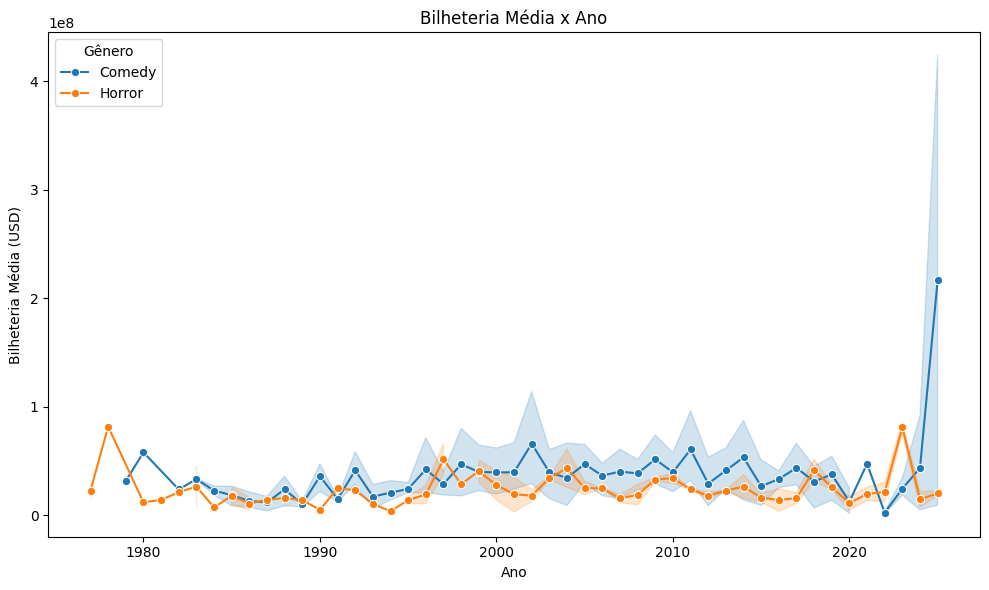

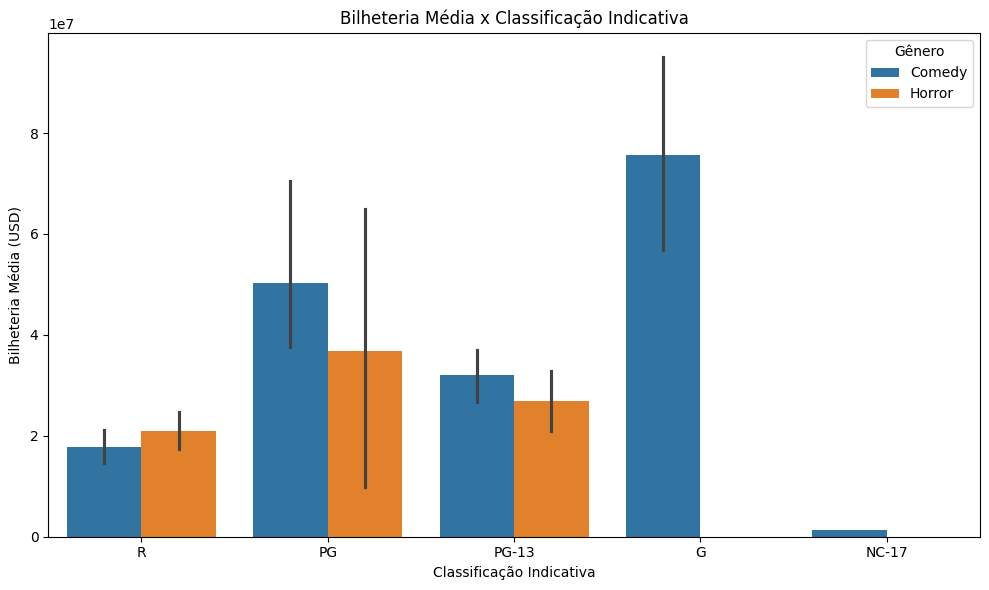

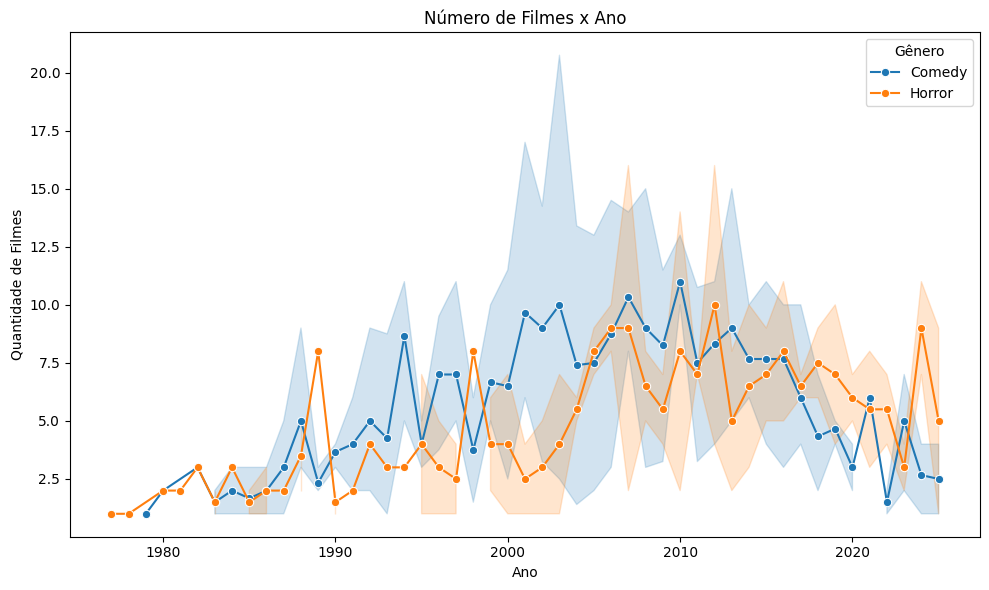

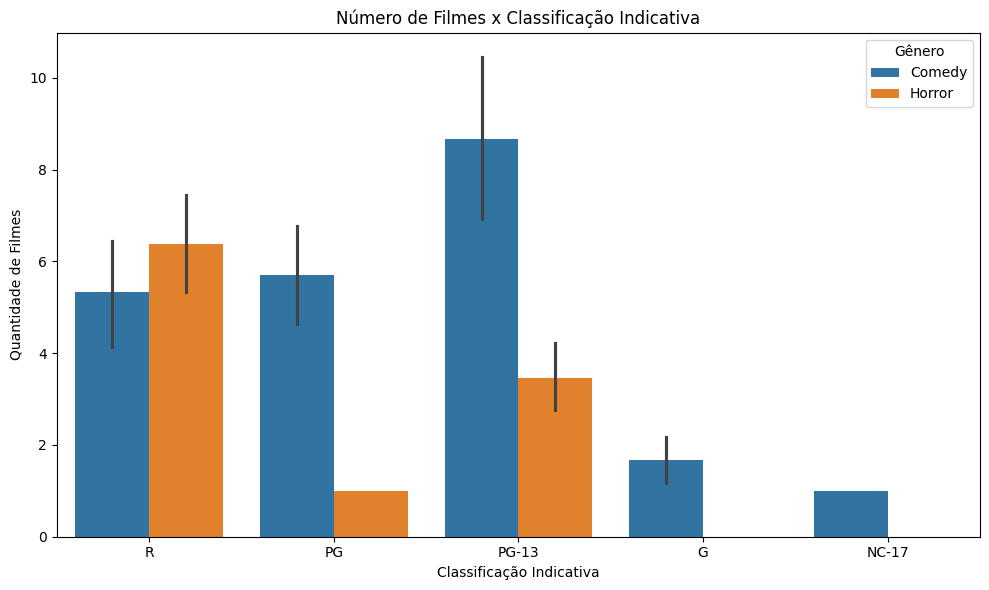

In [0]:
# Consulta SQL para análise
query = """
SELECT 
    g.Nome_Genero,
    t.Ano,
    c.Classificacao_Indicativa,
    AVG(f.Bilheteria_USD) as Media_Bilheteria,
    COUNT(f.ID_Filme) as Qtd_Filmes
FROM Fato_Filme f
JOIN Bridge_Filme_Genero bg ON f.ID_Filme = bg.FK_Filme
JOIN Dim_Genero g ON bg.FK_Genero = g.PK_Genero
JOIN Dim_Tempo t ON f.FK_Tempo_Lancamento = t.PK_Tempo
JOIN Dim_Classificacao c ON f.FK_Classificacao = c.PK_Classificacao
WHERE 
    f.Nota_IMDb < 6.0 
    AND f.Votos_IMDb > 10000
    AND g.Nome_Genero IN ('Horror', 'Comedy')
    AND c.Classificacao_Indicativa != "Não Classificado"
    AND f.Bilheteria_USD IS NOT NULL
GROUP BY g.Nome_Genero, t.Ano, c.Classificacao_Indicativa
ORDER BY g.Nome_Genero, t.Ano DESC
"""

# Executa consulta e carrega em DataFrame
df = spark.sql(query).toPandas()

display(df)

import matplotlib.pyplot as plt
import seaborn as sns

# Bilheteria x Ano
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='Ano', y='Media_Bilheteria', hue='Nome_Genero', marker='o')
plt.title('Bilheteria Média x Ano')
plt.ylabel('Bilheteria Média (USD)')
plt.xlabel('Ano')
plt.legend(title='Gênero')
plt.tight_layout()
plt.show()

# Bilheteria x Classificação Indicativa
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Classificacao_Indicativa', y='Media_Bilheteria', hue='Nome_Genero')
plt.title('Bilheteria Média x Classificação Indicativa')
plt.ylabel('Bilheteria Média (USD)')
plt.xlabel('Classificação Indicativa')
plt.legend(title='Gênero')
plt.tight_layout()
plt.show()

# Número de Filmes x Ano
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='Ano', y='Qtd_Filmes', hue='Nome_Genero', marker='o')
plt.title('Número de Filmes x Ano')
plt.ylabel('Quantidade de Filmes')
plt.xlabel('Ano')
plt.legend(title='Gênero')
plt.tight_layout()
plt.show()

# Número de Filmes x Classificação Indicativa
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Classificacao_Indicativa', y='Qtd_Filmes', hue='Nome_Genero')
plt.title('Número de Filmes x Classificação Indicativa')
plt.ylabel('Quantidade de Filmes')
plt.xlabel('Classificação Indicativa')
plt.legend(title='Gênero')
plt.tight_layout()
plt.show()

In [0]:
# Consulta para identificar os filmes de Comédia de 2024 e 2025 com alta bilheteria
# que estão causando o 'outlier' no gráfico de Bilheteria x Ano

df = spark.sql("""
SELECT
    f.ID_Filme,
    s.Titulo,
    t.Ano,
    c.Classificacao_Indicativa,
    f.Nota_IMDb,
    f.Votos_IMDb,
    f.Bilheteria_USD
FROM
    Fato_Filme f
JOIN
    Bridge_Filme_Genero bg ON f.ID_Filme = bg.FK_Filme
JOIN
    Dim_Genero g ON bg.FK_Genero = g.PK_Genero
JOIN
    Dim_Tempo t ON f.FK_Tempo_Lancamento = t.PK_Tempo
JOIN
    Dim_Classificacao c ON f.FK_Classificacao = c.PK_Classificacao
JOIN
    silver_clean s ON f.ID_Filme = s.ID_Filme
WHERE
    g.Nome_Genero = 'Comedy'
    AND t.Ano IN (2024, 2025)
    AND f.Bilheteria_USD IS NOT NULL
ORDER BY
    f.Bilheteria_USD DESC
""")

display(df)

ID_Filme Titulo Ano Classificacao_Indicativa Nota_IMDb Votos_IMDb Bilheteria_USD tt3566834 A Minecraft Movie 2025 PG 5.6 143481 4.23949195E8 tt5779228 The Garfield Movie 2024 PG 5.7 26336 9.1956547E7 tt11762114 Mean Girls 2024 PG-13 5.5 39573 7.258177E7 tt15009428 Argylle 2024 PG-13 5.6 96988 4.5207275E7 tt30788842 Love Hurts 2025 R 5.3 16399 1.568309E7 tt4978420 Borderlands 2024 PG-13 4.7 54260 1.5482668E7 tt28443655 Death of a Unicorn 2025 R 5.9 43979 1.2899252E7 tt30645201 Honey Don't! 2025 R 5.3 16834 5810510.0 tt0327785 The Killer's Game 2024 R 5.8 19683 5404378.0 tt19356262 Drive-Away Dolls 2024 R 5.4 26614 5028215.0 tt27218960 Y2K 2024 R 4.7 18836 4446596.0 tt1633359 The Toxic Avenger 2025 R 5.9 11317 2866783.0 tt30007864 The American Society of Magical Negroes 2024 PG-13 3.8 12662 2480645.0 tt26932223 Bhool Bhulaiyaa 3 2024 Não Classificado 4.6 78477 2230000.0 tt21383812 Crew 2024 Não Classificado 5.8 39168 1500000.0 tt9104736 Housefull 5 2025 Não Classificado 3.4 17691 1152549.0 tt24517830 Bad Newz 2024 Não Classificado 4.7 27417 1069000.0

### Discussão dos Resultados - Análise 1

A principal conclusão é que **filmes de Comédia possuem uma bilheteria média, em geral, maior do que filmes de Terror**, mas este desempenho é fortemente modulado pela classificação indicativa e por tendências de mercado.

#### Principais Achados Visuais:

1.  No gráfico de **Média de Bilheteria por Ano**, a linha da Comédia (laranja) se mantém consistentemente acima da linha do Terror (roxa) na maior parte das últimas quatro décadas. Historicamente, um filme de comédia que "fracassa" criticamente tende a arrecadar mais do que um filme de terror na mesma situação, sugerindo uma segurança financeira mais robusta para o gênero.

2.  O gráfico de **Média de Bilheteria por Classificação** mostra que filmes de Comédia com classificação **"G"** (para todos os públicos) atingem uma média de bilheteria de quase **$80 milhões**. A única classificação com uma média maior para filmes de Terror é **R**, visto que também é a única que possuí mais filmes de Terror do que de Comédia, como visto no gráfico de **Número de Filmes por Classificação**. 
O público familiar é um fator de mitigação de risco. Decisões de ir ao cinema são menos influenciadas por críticas e mais por marketing e adequação de idade. Filmes com classificação "NC-17", por outro lado, representam o maior risco financeiro, visto que a maioria dos cinemas se recusa a exibir filmes com conteúdo adulto.

3.  O gráfico de **Número de Filmes por Ano** revela uma alta na produção de comédias mal avaliadas entre o final dos anos 90 e meados dos anos 2000, com um pico de quase 40 filmes anuais. A produção de terror cresceu mais tarde, mas se manteve mais estável. 
O período de alta produção de comédias coincide com uma bilheteria média elevada, sugerindo um mercado aquecido e saturado, onde até mesmo os fracassos eram financeiramente viáveis. A recente queda no volume pode indicar maior cautela por parte dos estúdios.

4.  O gráfico de **Média de Bilheteria por Ano** exibe um pico anômalo para comédias em 2025, superando os $200 milhões.
  A Causa Principal Identificada foi o filme **"A Minecraft Movie"** (2025), com uma bilheteria de **mais de $423 milhões**, ele sozinho eleva drasticamente a média do ano. Sua arrecadação é mais de **4.5 vezes maior** que a do segundo colocado ("The Garfield Movie"). É crucial notar que "A Minecraft Movie" e "The Garfield Movie" possuem classificação **"PG"** e ambos são baseados em obras extremamente populares e consolidadas com o público infantil e familiar. Isso reforça a conclusão anterior de que filmes de baixa avaliação crítica podem se tornar enormes sucessos comerciais se conseguirem capturar o mercado familiar.

#### **Conclusão: Cinema Familiar é Mais Lucrativo**

Para um estúdio de cinema que busca minimizar perdas, a análise sugere que **investir em comédias de apelo familiar (classificação G ou PG) é a aposta mais segura**, mesmo com risco de baixa qualidade. O gênero terror, apesar de seu potencial de lucro, carrega um risco financeiro maior em caso de fracasso.


### Títulos populares da última década com avaliação abaixo de 6.0

<img src="https://m.media-amazon.com/images/M/MV5BYzFjMzNjOTktNDBlNy00YWZhLWExYTctZDcxNDA4OWVhOTJjXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg" width="300">
<img src="https://m.media-amazon.com/images/M/MV5BMjI0NTc3MjU5M15BMl5BanBnXkFtZTcwODM4Nzg2Mg@@._V1_FMjpg_UX1000_.jpg" width="300">
<img src="https://upload.wikimedia.org/wikipedia/pt/thumb/1/1a/Age_of_Extinction.jpg/250px-Age_of_Extinction.jpg" width="300">

### 5.2 Análise 2: Diretores Consistentes em Baixa Qualidade
Quais são os diretores que, na última década, dirigiram 3 ou mais filmes de um mesmo gênero com avaliação inferior a 6.0? 

Para estes diretores, qual foi a evolução da nota média de seus filmes nesse gênero específico, ano a ano?

In [0]:
from pyspark.sql import functions as F

# Criação da view temporária
diretores_alvo = (
    spark.table("Fato_Filme")
    .join(spark.table("Dim_Tempo"), F.col("Fato_Filme.FK_Tempo_Lancamento") == F.col("Dim_Tempo.PK_Tempo"))
    .join(spark.table("Bridge_Filme_Diretor"), F.col("Fato_Filme.ID_Filme") == F.col("Bridge_Filme_Diretor.FK_Filme"))
    .join(spark.table("Dim_Diretor"), F.col("Bridge_Filme_Diretor.FK_Diretor") == F.col("Dim_Diretor.PK_Diretor"))
    .join(spark.table("Bridge_Filme_Genero"), F.col("Fato_Filme.ID_Filme") == F.col("Bridge_Filme_Genero.FK_Filme"))
    .join(spark.table("Dim_Genero"), F.col("Bridge_Filme_Genero.FK_Genero") == F.col("Dim_Genero.PK_Genero"))
    .where(
        (F.col("Fato_Filme.Nota_IMDb") < 6.0) &
        (F.col("Dim_Tempo.Ano") >= (F.year(F.current_date()) - 10))
    )
    .groupBy("Dim_Diretor.Nome_Diretor", "Dim_Genero.Nome_Genero")
    .agg(F.countDistinct("Fato_Filme.ID_Filme").alias("Qtd_Ruins_Decada"))
    .where(F.col("Qtd_Ruins_Decada") >= 3)
)

view_analise_diretores = (
    spark.table("Fato_Filme")
    .join(spark.table("Dim_Tempo"), F.col("Fato_Filme.FK_Tempo_Lancamento") == F.col("Dim_Tempo.PK_Tempo"))
    .join(spark.table("Bridge_Filme_Diretor"), F.col("Fato_Filme.ID_Filme") == F.col("Bridge_Filme_Diretor.FK_Filme"))
    .join(spark.table("Dim_Diretor"), F.col("Bridge_Filme_Diretor.FK_Diretor") == F.col("Dim_Diretor.PK_Diretor"))
    .join(spark.table("Bridge_Filme_Genero"), F.col("Fato_Filme.ID_Filme") == F.col("Bridge_Filme_Genero.FK_Filme"))
    .join(spark.table("Dim_Genero"), F.col("Bridge_Filme_Genero.FK_Genero") == F.col("Dim_Genero.PK_Genero"))
    .join(
        diretores_alvo.alias("alvo"),
        (F.col("Dim_Diretor.Nome_Diretor") == F.col("alvo.Nome_Diretor")) &
        (F.col("Dim_Genero.Nome_Genero") == F.col("alvo.Nome_Genero"))
    )
    .where(F.col("Dim_Tempo.Ano") >= (F.year(F.current_date()) - 10))
    .groupBy(
        F.col("Dim_Diretor.Nome_Diretor"), 
        F.col("Dim_Genero.Nome_Genero"), 
        F.col("alvo.Qtd_Ruins_Decada"), 
        F.col("Dim_Tempo.Ano")
    )
    .agg(
        F.countDistinct("Fato_Filme.ID_Filme").alias("Qtd_Filmes_Ano_Geral"),
        F.round(F.avg("Fato_Filme.Nota_IMDb"), 2).alias("Nota_Media_Ano_Geral")
    )
)

display(view_analise_diretores.head(20))
print(f"Número de linhas da View: ", view_analise_diretores.count())

Nome_Diretor Nome_Genero Qtd_Ruins_Decada Ano Qtd_Filmes_Ano_Geral Nota_Media_Ano_Geral Becca Hirani Thriller 3 2021 1 3.6 Becca Hirani Thriller 3 2022 2 2.9 Mikhail Red Drama 3 2025 1 5.4 Mikhail Red Drama 3 2019 1 5.3 Mikhail Red Drama 3 2022 1 5.2 Mikhail Red Drama 3 2024 1 6.0 Mikhail Red Drama 3 2016 1 6.6 Lewis Leslie Horror 3 2017 1 5.8 Lewis Leslie Horror 3 2018 1 3.6 Lewis Leslie Horror 3 2016 1 5.8 Steven M. Smith Horror 19 2025 3 3.63 Steven M. Smith Horror 19 2020 3 3.8 Steven M. Smith Horror 19 2021 5 3.26 Steven M. Smith Horror 19 2023 1 3.6 Steven M. Smith Horror 19 2019 3 2.9 Steven M. Smith Horror 19 2018 2 2.05 Steven M. Smith Horror 19 2017 2 2.5 Geovanni Molina Thriller 3 2022 2 3.05 DW Medoff Horror 3 2025 1 4.8 Geovanni Molina Thriller 3 2025 1 2.6

Número de linhas da View:  10164


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Nome_Diretor Nome_Genero Qtd_Ruins_Decada Ano Qtd_Filmes_Ano_Geral Nota Média Rank_Top Diretor_Genero Dustin Ferguson Horror 72 2016 5 2.64 1 Dustin Ferguson - Horror Dustin Ferguson Horror 72 2017 4 3.5 1 Dustin Ferguson - Horror Dustin Ferguson Horror 72 2018 11 3.85 1 Dustin Ferguson - Horror Dustin Ferguson Horror 72 2019 4 4.4 1 Dustin Ferguson - Horror Dustin Ferguson Horror 72 2020 15 2.67 1 Dustin Ferguson - Horror Dustin Ferguson Horror 72 2021 12 2.91 1 Dustin Ferguson - Horror Dustin Ferguson Horror 72 2022 4 4.45 1 Dustin Ferguson - Horror Dustin Ferguson Horror 72 2023 12 3.53 1 Dustin Ferguson - Horror Dustin Ferguson Horror 72 2024 8 4.05 1 Dustin Ferguson - Horror Dustin Ferguson Horror 72 2025 1 7.8 1 Dustin Ferguson - Horror Tony Newton Horror 48 2016 6 4.37 2 Tony Newton - Horror Tony Newton Horror 48 2017 7 5.0 2 Tony Newton - Horror Tony Newton Horror 48 2018 17 4.32 2 Tony Newton - Horror Tony Newton Horror 48 2019 2 5.85 2 Tony Newton - Horror Tony Newton Horror 48 2020 9 4.26 2 Tony Newton - Horror Tony Newton Horror 48 2021 8 3.36 2 Tony Newton - Horror Tony Newton Horror 48 2022 4 4.45 2 Tony Newton - Horror Tony Newton Horror 48 2024 1 3.4 2 Tony Newton - Horror Sam Mason-Bell Horror 42 2016 2 4.9 3 Sam Mason-Bell - Horror Sam Mason-Bell Horror 42 2017 4 5.3 3 Sam Mason-Bell - Horror Sam Mason-Bell Horror 42 2018 13 3.82 3 Sam Mason-Bell - Horror Sam Mason-Bell Horror 42 2019 4 3.98 3 Sam Mason-Bell - Horror Sam Mason-Bell Horror 42 2020 3 3.6 3 Sam Mason-Bell - Horror Sam Mason-Bell Horror 42 2021 5 3.74 3 Sam Mason-Bell - Horror Sam Mason-Bell Horror 42 2022 7 3.46 3 Sam Mason-Bell - Horror Sam Mason-Bell Horror 42 2023 4 4.2 3 Sam Mason-Bell - Horror Sam Mason-Bell Horror 42 2024 1 3.4 3 Sam Mason-Bell - Horror Sam Mason-Bell Horror 42 2025 1 6.1 3 Sam Mason-Bell - Horror Mark Polonia Horror 37 2017 3 2.8 4 Mark Polonia - Horror Mark Polonia Horror 37 2018 3 2.27 4 Mark Polonia - Horror Mark Polonia Horror 37 2019 3 3.27 4 Mark Polonia - Horror Mark Polonia Horror 37 2020 4 2.7 4 Mark Polonia - Horror Mark Polonia Horror 37 2021 5 2.74 4 Mark Polonia - Horror Mark Polonia Horror 37 2022 3 2.67 4 Mark Polonia - Horror Mark Polonia Horror 37 2023 3 2.77 4 Mark Polonia - Horror Mark Polonia Horror 37 2024 9 3.38 4 Mark Polonia - Horror Mark Polonia Horror 37 2025 4 3.13 4 Mark Polonia - Horror Jordan Hill Documentary 34 2017 2 7.3 5 Jordan Hill - Documentary Jordan Hill Documentary 34 2018 10 3.98 5 Jordan Hill - Documentary Jordan Hill Documentary 34 2019 11 5.27 5 Jordan Hill - Documentary Jordan Hill Documentary 34 2020 13 4.48 5 Jordan Hill - Documentary Jordan Hill Documentary 34 2021 12 5.53 5 Jordan Hill - Documentary Jordan Hill Documentary 34 2022 1 7.1 5 Jordan Hill - Documentary Jordan Hill Documentary 34 2023 2 5.45 5 Jordan Hill - Documentary Jordan Hill Documentary 34 2024 2 4.9 5 Jordan Hill - Documentary

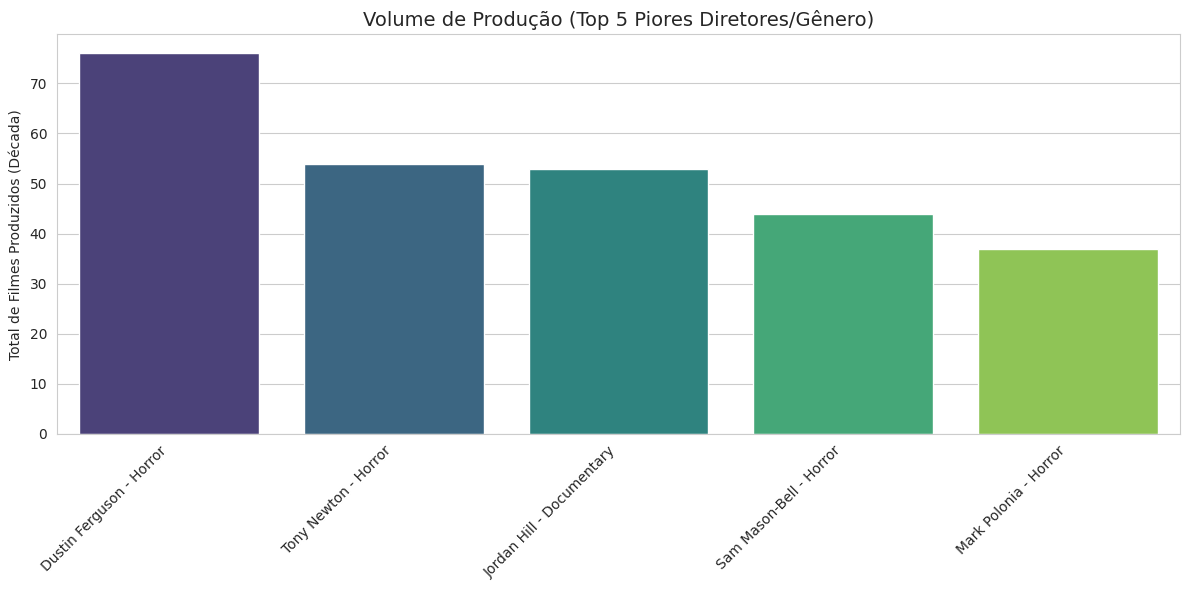

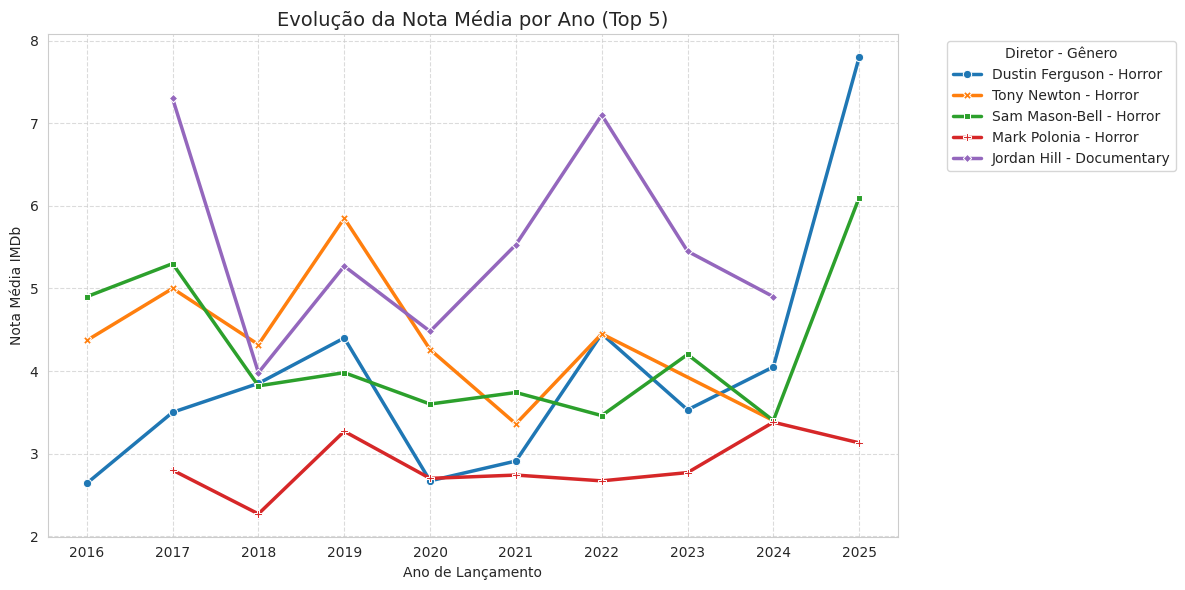

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:
# Top 5 Diretores/Gêneros

window_spec = Window.orderBy(F.col("Qtd_Ruins_Decada").desc())

df_top_diretores = (
    view_analise_diretores
    .withColumn("Rank_Top", F.dense_rank().over(window_spec))
    .filter(F.col("Rank_Top") <= 5)
    .withColumn(
        "Diretor_Genero",
        F.concat_ws(" - ", F.col("Nome_Diretor"), F.col("Nome_Genero"))
    )
    .withColumnRenamed("Nota_Media_Ano_Geral", "Nota Média")
    .orderBy("Rank_Top", "Nome_Diretor", "Ano")
)

pdf_top = df_top_diretores.toPandas()

display(df_top_diretores)

sns.set_style("whitegrid") 

# Gráfico 1: Total de Filmes na Década por Dupla
plt.figure(figsize=(12, 6))

pdf_barras = pdf_top.groupby("Diretor_Genero")["Qtd_Filmes_Ano_Geral"].sum().reset_index()
pdf_barras = pdf_barras.sort_values("Qtd_Filmes_Ano_Geral", ascending=False)

ax1 = sns.barplot(
    data=pdf_barras, 
    x="Diretor_Genero", 
    y="Qtd_Filmes_Ano_Geral", 
    palette="viridis", 
    hue="Diretor_Genero"
)

plt.title("Volume de Produção (Top 5 Piores Diretores/Gênero)", fontsize=14)
plt.ylabel("Total de Filmes Produzidos (Década)")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

# Gráfico 2: Evolução da Nota Média
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=pdf_top, 
    x="Ano", 
    y="Nota Média", 
    hue="Diretor_Genero", 
    style="Diretor_Genero",
    markers=True, 
    dashes=False, 
    palette="tab10",
    linewidth=2.5
)

plt.title("Evolução da Nota Média por Ano (Top 5)", fontsize=14)
plt.ylabel("Nota Média IMDb")
plt.xlabel("Ano de Lançamento")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Diretor - Gênero")
plt.grid(True, linestyle='--', alpha=0.7)

from matplotlib.ticker import MaxNLocator
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

### Discussão dos Resultados - Análise 2

A análise dos diretores com produção consistente de filmes mal avaliados revela um padrão nos dados que apontam diretamente para um nicho específico e intencional do mercado cinematográfico: o **"cinema trash" ou de "baixo orçamento" (low-budget/B-movie)**, predominantemente no gênero de Terror.

#### Principais Achados Visuais:

1.  O gráfico de barras destaca **Dustin Ferguson**, um nome conhecido no cinema trash, com mais de 70 filmes na última década. Os outros diretores, como Tony Newton e Mark Polonia, também são figuras prolíficas nesse cenário. A produção em alto volume, com baixíssimos orçamentos e ciclos rápidos, é uma característica fundamental do cinema trash. O objetivo não é a aclamação, mas a geração contínua de conteúdo para um público de nicho específico.

2. O gráfico de linhas ("Nota Média") mostra uma performance extremamente volátil, operando consistentemente abaixo do limiar de 6.0. Diretores como Jordan Hill (amarela) e Tony Newton (azul claro) atingem picos de qualidade em certos anos, intercalados com anos de performance muito baixa. No geral, a maioria dos diretores se enquadram no que define o "cinema trash".
Nessas produções, as métricas tradicionais de qualidade são irrelevantes. A "baixa qualidade" (atuações exageradas, efeitos práticos baratos, roteiros absurdos) é, muitas vezes, parte do apelo estético para os fãs do gênero e o terror é historicamente o lar do cinema de baixo orçamento, pois não depende de grandes estrelas ou efeitos visuais caros para gerar sustos ou entretenimento. A instabilidade das notas reflete a natureza experimental dessas produções.

#### **Conclusão: Identificando um Nicho**

A principal conclusão estratégica desta análise é a identificação de um grupo de **diretores especialistas que têm sucesso dentro das regras de um nicho de mercado específico: o cinema trash**. Para um estúdio ou distribuidor, a decisão de trabalhar com esses cineastas é um risco se o objetivo for prestígio ou apelo ao grande público. No entanto, para plataformas de streaming ou canais de TV a cabo que precisam de um grande volume de conteúdo de nicho para preencher seus catálogos, esses diretores são muito requisitados. Eles entregam um fluxo constante de produtos com um público-alvo definido e, presumivelmente, a um custo de aquisição muito baixo.

### Imagem de Perfil de *Dustin Ferguson* no IMDb
<img src="https://m.media-amazon.com/images/M/MV5BYzNjOTNmYzItNWEyYS00NzY3LWE2YzUtY2M5OTgzNGZkYjk5XkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg" width="500">

### Títulos Populares

<img src="https://m.media-amazon.com/images/M/MV5BMDhmYjk1YTQtMGFhZC00MzM1LTlhMGMtY2NjZjUzYTEwYzM3XkEyXkFqcGc@._V1_.jpg" width="300">
<img src="https://m.media-amazon.com/images/M/MV5BYzgzZDljZTUtNDk1NC00ZjNiLWIxNDEtODlkMjljN2M4OTBkXkEyXkFqcGc@._V1_.jpg" width="300">
<img src="https://m.media-amazon.com/images/M/MV5BN2E5YTNhMDYtMzY3OC00MTk2LWJhZWMtZGQ4YzdmNjUzNzlhXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg" width="300">

### 5.3 Análise 3: Duplas Diretor-Roteirista em Baixo Desempenho
Quais são as duplas de diretor e roteirista que mais trabalharam juntas em filmes de baixo desempenho?

In [0]:
view_analise_duplas = (
    spark.sql("""
        SELECT 
            d.Nome_Diretor,
            r.Nome_Roteirista,
            COUNT(DISTINCT f.ID_Filme) as Qtd_Filmes_Ruins,
            AVG(f.Nota_IMDb) as Media_Nota_Conjunta,
            CONCAT(d.Nome_Diretor, ' - ', r.Nome_Roteirista) as Diretor_Roteirista
        FROM Fato_Filme f
        JOIN Bridge_Filme_Diretor bd ON f.ID_Filme = bd.FK_Filme
        JOIN Dim_Diretor d ON bd.FK_Diretor = d.PK_Diretor
        JOIN Bridge_Filme_Roteirista br ON f.ID_Filme = br.FK_Filme
        JOIN Dim_Roteirista r ON br.FK_Roteirista = r.PK_Roteirista
        WHERE 
            f.Nota_IMDb < 6.0
            AND d.Nome_Diretor <> r.Nome_Roteirista 
        GROUP BY d.Nome_Diretor, r.Nome_Roteirista
        ORDER BY Qtd_Filmes_Ruins DESC, Media_Nota_Conjunta ASC
    """)
)

view_analise_duplas.createOrReplaceTempView("View_Analise_Duplas")
print("Número de linhas da View:", spark.sql("SELECT COUNT(*) FROM View_Analise_Duplas").collect()[0][0])

Número de linhas da View: 213281


Nome_Diretor Nome_Roteirista Qtd_Filmes_Ruins Media_Nota_Conjunta Diretor_Roteirista Carlo Vanzina Enrico Vanzina 55 4.761818181818182 Carlo Vanzina - Enrico Vanzina Godfrey Ho AAV Creative Unit 48 4.179166666666666 Godfrey Ho - AAV Creative Unit Sirri Gültekin Sadik Sendil 36 4.955555555555555 Sirri Gültekin - Sadik Sendil Omiros Efstratiadis Giannis Sklavos 34 4.379411764705883 Omiros Efstratiadis - Giannis Sklavos Claude Pierson Huguette Boisvert 33 4.869696969696969 Claude Pierson - Huguette Boisvert Franz Antel Kurt Nachmann 32 4.699999999999999 Franz Antel - Kurt Nachmann Chris Stokes Marques Houston 29 4.717241379310345 Chris Stokes - Marques Houston Ülkü Erakalin Bülent Oran 29 5.1000000000000005 Ülkü Erakalin - Bülent Oran Kostas Karagiannis Lakis Mihailidis 28 4.321428571428571 Kostas Karagiannis - Lakis Mihailidis James Snider BC Fourteen 26 3.55 James Snider - BC Fourteen Sam Newfield Fred Myton 25 5.26 Sam Newfield - Fred Myton Nayato Fio Nuala Ery Sofid 24 4.158333333333333 Nayato Fio Nuala - Ery Sofid Bruno Corbucci Mario Amendola 22 5.295454545454546 Bruno Corbucci - Mario Amendola Türker Inanoglu Fuat Özlüer 21 5.428571428571428 Türker Inanoglu - Fuat Özlüer Claudio Fragasso Rossella Drudi 20 4.385 Claudio Fragasso - Rossella Drudi

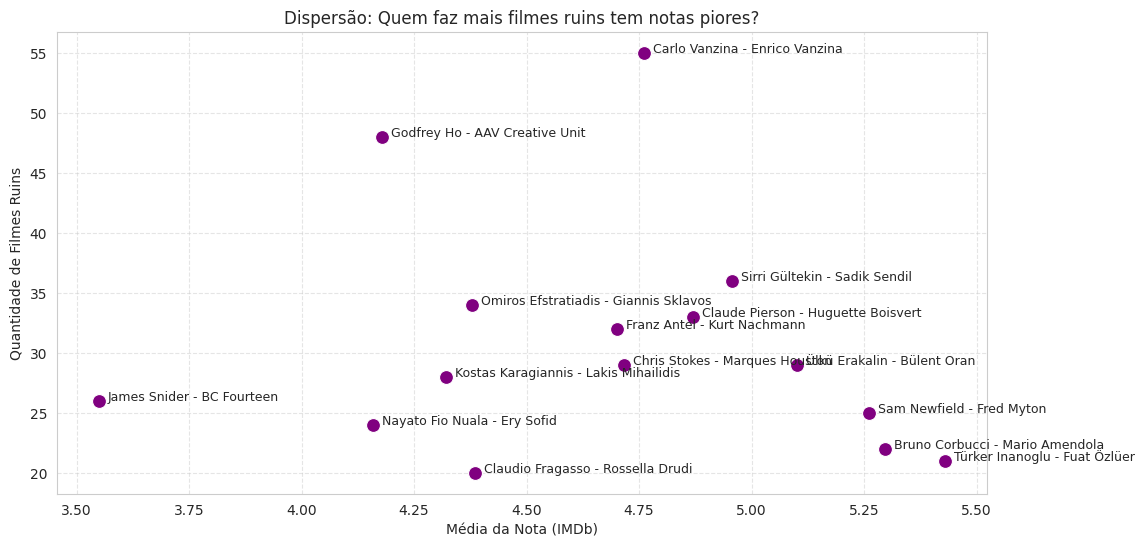

In [0]:
import pyspark.sql.functions as F

df_duplas = spark.sql("""
SELECT * FROM View_Analise_Duplas 
LIMIT 15
""")

df_duplas = df_duplas.withColumn(
    "Diretor_Roteirista",
    F.concat_ws(" - ", F.col("Nome_Diretor"), F.col("Nome_Roteirista"))
)

display(df_duplas)

plt.figure(figsize=(12, 6))

sns.scatterplot(data=pdf_duplas, x="Media_Nota_Conjunta", y="Qtd_Filmes_Ruins", s=100, color="purple")

for i in range(pdf_duplas.shape[0]):
    plt.text(
        pdf_duplas.Media_Nota_Conjunta[i]+0.02, 
        pdf_duplas.Qtd_Filmes_Ruins[i], 
        pdf_duplas.Diretor_Roteirista[i], 
        fontsize=9
    )

plt.title("Dispersão: Quem faz mais filmes ruins tem notas piores?")
plt.xlabel("Média da Nota (IMDb)")
plt.ylabel("Quantidade de Filmes Ruins")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Discussão dos Resultados - Análise 3

O gráfico de dispersão, que plota o volume de colaborações contra a qualidade média, permite identificar diferentes perfis de duplas criativas.

#### Principais Achados Visuais:

1.  O gráfico é dominado por dois outliers de volume massivo no eixo X. A dupla italiana **Carlo Vanzina - Enrico Vanzina** lidera com **55 filmes**, e **Godfrey Ho - AAV Creative Unit** segue com **48 filmes**.
Os irmãos Vanzina são conhecidos por suas comédias populares na Itália ("cinepanettone"), que, embora comercialmente bem-sucedidas, frequentemente recebem críticas negativas. Godfrey Ho é uma lenda do cinema de exploração de Hong Kong, famoso por seus filmes de artes marciais "cut-and-paste". O DW identificou com sucesso dois modelos de negócio baseados em produção em massa para mercados específicos.

2. A grande maioria das duplas se concentra na faixa de **20 a 35 filmes**, com notas médias que flutuam entre 3.5 e 5.5.
Isso representa o básico do cinema de baixo orçamento. São parcerias estáveis que encontraram uma fórmula para produzir conteúdo de gênero (provavelmente terror, ação ou comédia) de forma consistente e com foco em um público-alvo específico.

#### **Conclusão: Unidades Criativas**

Esta análise permitiu identificar algumas **"unidades criativas"** conhecidas:
*   Irmãos Vanzina, conhecidos por suas comédias populares italianas "cinepanettone".
*   Godfrey Ho e AAV Creative Unit, com filmes de ninja de edição caótia e de baixo orçamento, diretamente do cinema trash de Hong-Kong.

Duplas como as acima são importantes porque mantêm vivo o cinema popular, preenchem nichos culturais, alimentam a economia audiovisual e mostram que o cinema pode prosperar mesmo fora dos padrões de qualidade tradicionais.


### Irmãos Vanzina e Godfrey Ho

<img src="https://static.ilmanifesto.it/2022/09/carlo-vanzina-con-enrico-vanzina.jpeg" width="500">
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2CQew89egP6mjibd9kQr6b2QwCwDjadQU4w&s" width="250">

### Títulos Populares

<img src="https://m.media-amazon.com/images/M/MV5BM2Y3NzcyNDMtZTJlNC00OWM1LWFlZjItMjRjZmUwOGQ0NzY4XkEyXkFqcGc@._V1_.jpg" width="300">
<img src="https://m.media-amazon.com/images/M/MV5BMTY3MDQ3Nzk2MF5BMl5BanBnXkFtZTgwMTgyOTk1MDE@._V1_.jpg" width="300">

## 6. Conclusões Finais

O desenvolvimento deste Data Warehouse obteve sucesso no objetivo de transformar o complexo conjunto de dados brutos do IMDb em um ativo de inteligência acionável. Através de um pipeline ETL seguindo a arquitetura Medalhão (Bronze, Prata, Ouro), conseguimos limpar, enriquecer e modelar os dados para revelar padrões sobre filmes de baixo desempenho.

A implementação de um **Esquema Estrela com Tabelas Ponte** se provou essencial para modelar com precisão as relações de muitos-para-muitos (N:N) do domínio cinematográfico. Essa arquitetura permitiu a execução de consultas multidimensionais complexas de forma eficiente, mantendo a integridade dos dados.

Do ponto de vista analítico, o Data Warehouse demonstrou seu imenso valor nas conclusões de suas análises:

*   **Na Análise 1**, quantificamos o risco financeiro, revelando que comédias, especialmente as de apelo familiar, mesmo que mal avaliadas, possuem uma média de bilheteria muito maior que filmes do gênero de terror.
*   **Na Análise 2**, identificamos um nicho específico — o **"cinema trash"** — onde diretores trabalham com produções em massa de baixo orçamento, um padrão que o DW conseguiu distinguir de um simples "fracasso" crítico.
*   **Na Análise 3**, identificamos duplas de diretor-roteirista que funcionam como verdadeiras unidades de produção, trabalhando para manter o cinema popular vivo.

O principal desafio enfrentado foi a limitação da API OMDb, que exigiu o uso de várias chaves e restringiu o escopo da análise. No entanto, mesmo com essa limitação, o projeto conseguiu atingir os seus objetivos principais de requisitos de negócio.

Em suma, este trabalho não apenas entregou um repositório de dados, mas foi capaz de transformar perguntas de negócio complexas em respostas claras e baseadas em dados, validando o papel indispensável do Data Warehouse na extração de conhecimento estratégico.

### Contribuições dos Integrantes do Grupo

**Pedro Andrade Dorighello:**

*   **Modelagem e Implementação da Camada Ouro:** Criação das tabelas de Dimensão, das Tabelas Ponte e da Tabela Fato final.
*   **Desenvolvimento das Análises 2 e 3:** Desenvolvimento e otimização das consultas SQL para as **Análises 2 e 3**.
*   **Documentação Visual e Técnica:** Criou os diagramas do projeto: Diagrama do Modelo Dimensional e o Diagrama do Fluxo de ETL.
*   **Desenvolvimento Notebook:** Contribuiu na estruturação geral do código e das células Markdown do notebook.

**Jean Lucas Rocha dos Santos:**

*   **Pesquisa e Camada Bronze:** Conduziu a pesquisa inicial sobre os datasets do IMDb e a exploração da API OMDb. Foi o responsável por implementar o pipeline de ingestão da **Camada Bronze**, incluindo a leitura dos arquivos.
*   **Limpeza e Transformação na Camada Prata:** Limpeza, padronização e transformação de dados na Camada Prata, tratando colunas críticas como `BoxOffice`, `Released` e `Rated`, e garantindo a criação da tabela `silver_clean` com dados de alta qualidade.
*   **Desenvolvimento da Análise 1:** Construiu e documentou a consulta SQL para a **Análise 1**, gerando os insights visuais sobre o risco financeiro.
*   **Validação e Redação:** Participou da validação dos dados em todas as camadas e contribuiu na redação das seções explicativas e conclusões do relatório final no notebook.

## Apêndice: Estrutura das Tabelas

In [0]:
spark.table("Fato_Filme").describe().show()

+-------+---------+-------------------+-------------------+------------------+------------------+--------------------+
|summary| ID_Filme|FK_Tempo_Lancamento|   FK_Classificacao|         Nota_IMDb|        Votos_IMDb|      Bilheteria_USD|
+-------+---------+-------------------+-------------------+------------------+------------------+--------------------+
|  count|   338006|             337973|             338006|            338006|            338006|                1274|
|   mean|     NULL|  1515.757456956621| 3.9942190375318782| 6.124249569534258|3657.1189180073725|3.0154877600470956E7|
| stddev|     NULL|   69.5294102028722|0.14795044101344176|1.3754597176149774| 37267.15020694654| 3.426866133845553E7|
|    min|tt0000009|                  1|                  0|               1.0|                 5|               383.0|
|    max|tt9916730|               1548|                  5|              10.0|           3122268|        4.23949195E8|
+-------+---------+-------------------+---------

In [0]:
spark.table("dim_tempo").describe().show()

+-------+------------------+------------------+---------+--------+-----------------+
|summary|          PK_Tempo|               Ano|Trimestre|Mes_Nome|          Mes_Num|
+-------+------------------+------------------+---------+--------+-----------------+
|  count|              1548|              1547|     1416|    1416|             1416|
|   mean|             774.5|2003.7304460245637|     NULL|    NULL|6.538135593220339|
| stddev|447.01342261726325|20.609261347603358|     NULL|    NULL|3.387770635450587|
|    min|                 1|              1894|       T1|   Abril|                1|
|    max|              1548|              2025|       T4|Setembro|               12|
+-------+------------------+------------------+---------+--------+-----------------+



In [0]:
spark.table("Dim_Classificacao").describe().show()

+-------+------------------------+------------------+
|summary|Classificacao_Indicativa|  PK_Classificacao|
+-------+------------------------+------------------+
|  count|                       6|                 6|
|   mean|                    NULL|               2.5|
| stddev|                    NULL|1.8708286933869707|
|    min|                       G|                 0|
|    max|                       R|                 5|
+-------+------------------------+------------------+



In [0]:
spark.table("Dim_Diretor").describe().show()

+-------+----------+--------------------+
|summary|PK_Diretor|        Nome_Diretor|
+-------+----------+--------------------+
|  count|    150827|              150827|
|   mean|      NULL|                NULL|
| stddev|      NULL|                NULL|
|    min| nm0000005|'Atlas' Ramachandran|
|    max| nm9993694|  Þórunn Lárusdóttir|
+-------+----------+--------------------+



In [0]:
spark.table("Dim_Roteirista").describe().show()

+-------+-------------+------------------+
|summary|PK_Roteirista|   Nome_Roteirista|
+-------+-------------+------------------+
|  count|       233106|            233106|
|   mean|         NULL|              NULL|
| stddev|         NULL|              NULL|
|    min|    nm0000005|    'A.J.' Marriot|
|    max|    nm9993694|Þórunn Lárusdóttir|
+-------+-------------+------------------+



In [0]:
spark.table("Dim_Genero").describe().show()

+-------+-----------+-----------------+
|summary|Nome_Genero|        PK_Genero|
+-------+-----------+-----------------+
|  count|         28|               28|
|   mean|       NULL|             13.5|
| stddev|       NULL|8.225975119502044|
|    min|     Action|                0|
|    max|    Western|               27|
+-------+-----------+-----------------+



In [0]:
spark.table("Bridge_Filme_Roteirista").describe().show()

+-------+---------+-------------+
|summary| FK_Filme|FK_Roteirista|
+-------+---------+-------------+
|  count|   563739|       563739|
|   mean|     NULL|         NULL|
| stddev|     NULL|         NULL|
|    min|tt0000009|    nm0000005|
|    max|tt9916730|    nm9993694|
+-------+---------+-------------+



In [0]:
spark.table("Bridge_Filme_Diretor").describe().show()

+-------+---------+----------+
|summary| FK_Filme|FK_Diretor|
+-------+---------+----------+
|  count|   381003|    381003|
|   mean|     NULL|      NULL|
| stddev|     NULL|      NULL|
|    min|tt0000009| nm0000005|
|    max|tt9916730| nm9993694|
+-------+---------+----------+



In [0]:
spark.table("Bridge_Filme_Genero").describe().show()

+-------+---------+------------------+
|summary| FK_Filme|         FK_Genero|
+-------+---------+------------------+
|  count|   573415|            573415|
|   mean|     NULL|13.731754488459492|
| stddev|     NULL|   8.5905327050815|
|    min|tt0000009|                 0|
|    max|tt9916730|                27|
+-------+---------+------------------+



## Bibliografia
- https://www.databricks.com/br/glossary/star-schema
- https://www.omdbapi.com/
- https://imdbapi.dev/
- https://docs.databricks.com/aws/en/security/secrets/
- https://developer.imdb.com/non-commercial-datasets/
- https://docs.aws.amazon.com/pt_br/redshift/latest/dg/r_WF_DENSE_RANK.html
